—#— —F—a—s—h—i—o—n— —G—e—n—e—r—a—t—i—v—e— —S—t—u—d—i—o— —(—K—e—r—a—s—/—T—e—n—s—o—r—F—l—o—w— —V—e—r—s—i—o—n—)—
—#—#— —A— —C—o—m—p—l—e—t—e— —H—a—n—d—s—-—O—n— —P—r—o—j—e—c—t— —o—n— —G—e—n—e—r—a—t—i—v—e— —M—o—d—e—l—s—
—
—-—-—-—
—
—#—#— —P—r—o—j—e—c—t— —O—v—e—r—v—i—e—w—
—I—n— —t—h—i—s— —p—r—o—j—e—c—t—,— —w—e— —i—m—p—l—e—m—e—n—t— —a—n—d— —t—r—a—i—n— —t—w—o— —m—a—j—o—r— —f—a—m—i—l—i—e—s— —o—f— —g—e—n—e—r—a—t—i—v—e— —m—o—d—e—l—s— —u—s—i—n—g— —*—*—K—e—r—a—s—*—*— —a—n—d— —*—*—T—e—n—s—o—r—F—l—o—w—*—*—:—
—1—.— —*—*—V—a—r—i—a—t—i—o—n—a—l— —A—u—t—o—E—n—c—o—d—e—r— —(—V—A—E—)—*—*—
—2—.— —*—*—G—e—n—e—r—a—t—i—v—e— —A—d—v—e—r—s—a—r—i—a—l— —N—e—t—w—o—r—k— —(—G—A—N— —/— —D—C—G—A—N—)—*—*—
—
—D—a—t—a—:— —*—*—F—a—s—h—i—o—n—-—M—N—I—S—T—*—*—

—#— —P—h—a—s—e— —1— —�— —E—n—v—i—r—o—n—m—e—n—t— —a—n—d— —D—a—t—a— —P—r—e—p—a—r—a—t—i—o—n—

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Create output directory
os.makedirs('studio_outputs', exist_ok=True)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Load Data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Prepare data for VAE (normalized to [0, 1])
x_vae = x_train.astype("float32") / 255
x_vae = np.expand_dims(x_vae, -1)

# Prepare data for GAN (normalized to [-1, 1])
x_gan = (x_train.astype("float32") - 127.5) / 127.5
x_gan = np.expand_dims(x_gan, -1)

batch_size = 128

print(f"Data shape: {x_vae.shape}")

TensorFlow version: 2.19.0
Keras version: 3.10.0
Data shape: (60000, 28, 28, 1)


—#— —P—h—a—s—e— —2— —�— —V—a—r—i—a—t—i—o—n—a—l— —A—u—t—o—E—n—c—o—d—e—r— —(—V—A—E—)—

In [9]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 20

# Encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(), "reconstruction_loss": self.reconstruction_loss_tracker.result(), "kl_loss": self.kl_loss_tracker.result()}

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_vae, epochs=10, batch_size=128)

# Save VAE models
encoder.save('studio_outputs/vae_encoder.keras')
decoder.save('studio_outputs/vae_decoder.keras')
print('VAE models saved to studio_outputs/')

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - kl_loss: 10.2162 - loss: 349.5193 - reconstruction_loss: 339.3030
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - kl_loss: 16.0074 - loss: 250.5639 - reconstruction_loss: 234.5565
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 16.7306 - loss: 245.8127 - reconstruction_loss: 229.0821
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 17.0910 - loss: 243.8171 - reconstruction_loss: 226.7260
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 17.2547 - loss: 242.5806 - reconstruction_loss: 225.3258
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 17.3405 - loss: 241.7275 - reconstruction_loss: 224.3870
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 17.3771 - loss: 240.9561 - reconstruction_loss: 223.5789
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 17.3905 - loss: 240.4851 - reconstruction_loss: 223.0945
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━

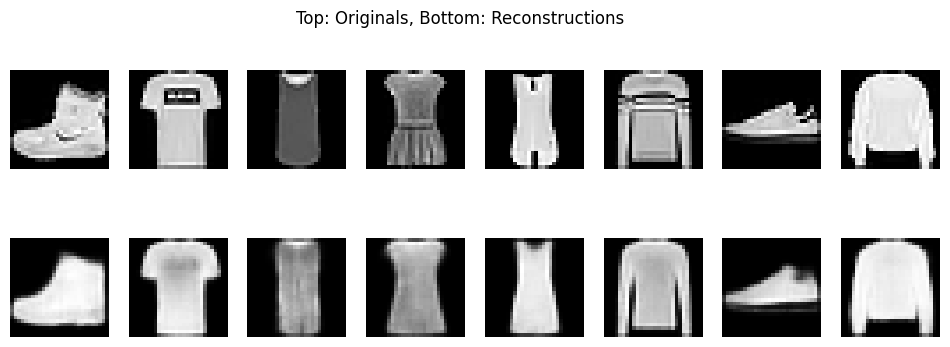

In [10]:
# VAE Visualization
def plot_reconstructions(model, images, n=8):
    _, _, z = model.encoder(images[:n])
    reconstructions = model.decoder(z)
    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        # Reconstruction
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.suptitle("Top: Originals, Bottom: Reconstructions")
    plt.show()

plot_reconstructions(vae, x_vae)

—#— —P—h—a—s—e— —3— —�— —G—e—n—e—r—a—t—i—v—e— —A—d—v—e—r—s—a—r—i—a—l— —N—e—t—w—o—r—k— —(—G—A—N—)—

In [11]:
latent_dim = 100

generator = keras.Sequential([
    layers.Dense(7 * 7 * 128, input_shape=(latent_dim,)),
    layers.Reshape((7, 7, 128)),
    layers.Conv2DTranspose(128, 4, strides=2, padding="same"),
    layers.BatchNormalization(), 
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(128, 4, strides=2, padding="same"),
    layers.BatchNormalization(), 
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(1, 7, padding="same", activation="tanh"),
], name="generator")

discriminator = keras.Sequential([
    layers.Conv2D(64, 3, strides=2, padding="same", input_shape=(28, 28, 1)),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),
    layers.Conv2D(128, 3, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid"),
], name="discriminator")

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
gan.fit(x_gan, epochs=20, batch_size=batch_size)

# Save GAN models
generator.save('studio_outputs/gan_generator.keras')
discriminator.save('studio_outputs/gan_discriminator.keras')
print('GAN models saved to studio_outputs/')

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - d_loss: 0.5989 - g_loss: 0.6919
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - d_loss: 0.6795 - g_loss: 0.6815
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - d_loss: 0.6566 - g_loss: 0.7292
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - d_loss: 0.6404 - g_loss: 0.7644
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - d_loss: 0.6745 - g_loss: 0.6996
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - d_loss: 0.6823 - g_loss: 0.6732
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - d_loss: 0.6826 - g_loss: 0.6789
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - d_loss: 0.6807 - g_loss: 0.6785
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - d_loss: 0.6802 - g_loss: 0.6756
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - d_loss: 0.6795 - g_loss: 0.6800
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - d_loss: 0.6795 - g_loss: 0.6761
Epoch 12/20
469/469 ━━━━━━━━━━

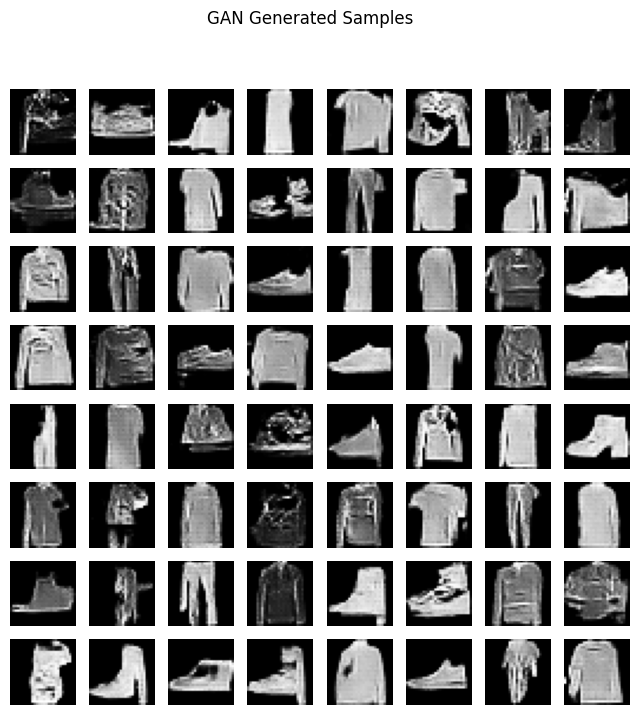

In [12]:
# GAN Visualization
random_latent_vectors = tf.random.normal(shape=(64, latent_dim))
generated_images = generator(random_latent_vectors)
generated_images = (generated_images + 1) / 2 # scale to [0, 1]

plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(generated_images[i].numpy().reshape(28, 28), cmap="gray")
    plt.axis("off")
plt.suptitle("GAN Generated Samples")
plt.show()

—#— —P—h—a—s—e— —4— —�— —E—v—a—l—u—a—t—i—o—n— —a—n—d— —C—o—m—p—a—r—i—s—o—n—

In [13]:
# Train a simple classifier to evaluate generated images
evaluator = keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])
evaluator.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
evaluator.fit(x_train.reshape(-1, 28, 28, 1)/255.0, y_train, epochs=3, batch_size=128)

def get_eval_stats(model_type='vae'):
    if model_type == 'vae':
        z = tf.random.normal(shape=(1000, 20))
        samples = vae.decoder(z)
    else:
        z = tf.random.normal(shape=(1000, 100))
        samples = (gan.generator(z) + 1) / 2
    
    preds = evaluator.predict(samples, verbose=0)
    avg_conf = np.mean(np.max(preds, axis=1))
    return avg_conf

vae_score = get_eval_stats('vae')
gan_score = get_eval_stats('gan')

print(f"VAE Avg Confidence: {vae_score:.4f}")
print(f"GAN Avg Confidence: {gan_score:.4f}")

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7471 - loss: 0.7124
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8758 - loss: 0.3541
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8931 - loss: 0.3027
VAE Avg Confidence: 0.6850
GAN Avg Confidence: 0.7399


—#— —P—h—a—s—e— —5— —�— —G—e—n—e—r—a—t—i—v—e— —P—l—a—y—g—r—o—u—n—d— —(—F—i—n—a—l— —D—e—m—o—)—

In [14]:
import ipywidgets as widgets
from IPython.display import display

def preview(model_type, seed):
    tf.random.set_seed(seed)
    if model_type == 'VAE':
        z = tf.random.normal(shape=(1, 20))
        img = vae.decoder(z).numpy().reshape(28, 28)
    else:
        z = tf.random.normal(shape=(1, 100))
        img = gan.generator(z).numpy().reshape(28, 28)
        img = (img + 1) / 2
    
    plt.imshow(img, cmap='gray')
    plt.title(f"{model_type} (Seed {seed})")
    plt.axis('off')
    plt.show()

model_drop = widgets.Dropdown(options=['VAE', 'GAN'], description='Model:')
seed_input = widgets.IntSlider(min=0, max=999, description='Seed:')
ui = widgets.HBox([model_drop, seed_input])
out = widgets.interactive_output(preview, {'model_type': model_drop, 'seed': seed_input})
display(ui, out)

Output()